In [1]:
from os.path import dirname, join as pjoin
import scipy.io as sio

In [2]:
mat_fname = 'ECoG_Handpose.mat'

In [3]:
mat_contents = sio.loadmat(mat_fname)['y']

In [4]:
mat_contents

array([[ 0.00000000e+00,  8.33333333e-04,  1.66666667e-03, ...,
         4.22518333e+02,  4.22519167e+02,  4.22520000e+02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.06701961e+05, -1.06699477e+05, -1.06697859e+05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -8.62051094e+04, -8.62023672e+04, -8.61986562e+04],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.53902262e-01,  1.53902262e-01,  1.53902262e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.61574081e-01,  1.61574081e-01,  1.61574081e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         2.34732822e-01,  2.34732822e-01,  2.34732822e-01]])

In [5]:
mat_data = mat_contents

In [6]:
mat_data.shape
# 67 channels
# channel 1 - sample time
# channel 2-61 - ECoG
# channel 62 - paradigm info
#              0 - relax
#              1 - fist movement
#              2 - peace movement
#              3 - open hand
# channel 63-67 - glove info
#              63 - thumb
#              64 - index
#              65 - middle
#              66 - ring
#              67 - little

(67, 507025)

In [7]:
import mne
import numpy as np
from scipy import signal

import matplotlib.pyplot as plt
from mne.time_frequency import fit_iir_model_raw
from mne.filter import create_filter

In [8]:
# extract ecog channels into nparray
ecog_data = mat_data[1:61]

In [9]:
paradigm_info = mat_data[61]

In [10]:
# count unique movements (labels?)
np.unique(paradigm_info, return_counts=True)

(array([0., 1., 2., 3.]), array([286801,  73440,  73440,  73344]))

In [11]:
mat_data[0]

array([0.00000000e+00, 8.33333333e-04, 1.66666667e-03, ...,
       4.22518333e+02, 4.22519167e+02, 4.22520000e+02])

# CREATE MNE OBJECT

In [12]:
sampling_freq = 1200
ch_names = ["sample_time"] + [f'CH_{i}' for i in range(1, 61)] + ["paradigm_info"]
ch_types = ['misc'] + ['ecog'] * 60 + ['stim']

In [13]:
len(ch_names), len(ch_types)

(62, 62)

In [14]:
info = mne.create_info(ch_names=ch_names, sfreq=1200, ch_types=ch_types)

In [15]:
raw = mne.io.RawArray(mat_data[0:62, :], info)

Creating RawArray with float64 data, n_channels=62, n_times=507025
    Range : 0 ... 507024 =      0.000 ...   422.520 secs
Ready.


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 1.707 (s)


/home/saras/miniconda3/envs/bci/lib/python3.10/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


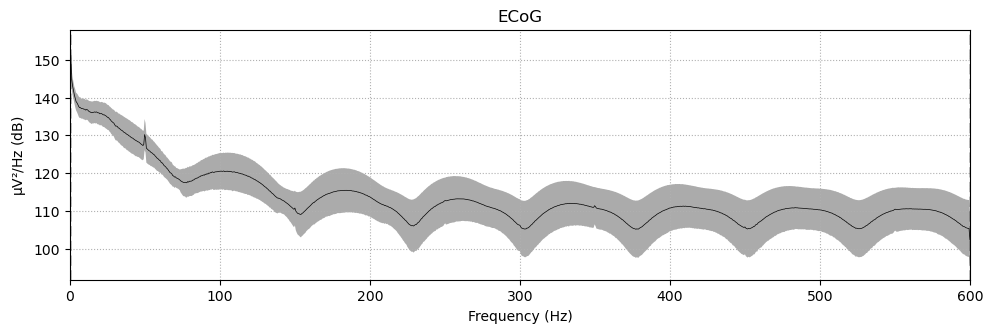

In [16]:
# plot ECoG channels only
raw.plot_psd(average=True)
plt.show();

In [17]:
# # plot all channels individually over time using matplotlib

# fig, axes = plt.subplots(60, 1, figsize=(10, 60))
# for i, ax in enumerate(axes):
#     ax.plot(ecog_data[i])
#     ax.set_title(raw.ch_names[i])

# fig.tight_layout()
# plt.show()
# plt.close()

In [18]:
# show info on the raw object
raw.info

<Info | 7 non-empty values
 bads: []
 ch_names: sample_time, CH_1, CH_2, CH_3, CH_4, CH_5, CH_6, CH_7, CH_8, ...
 chs: 1 misc, 60 ECoG, 1 Stimulus
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 600.0 Hz
 meas_date: unspecified
 nchan: 62
 projs: []
 sfreq: 1200.0 Hz
>

In [19]:
sample_time = mat_data[0, :]

In [20]:
time_diff = np.diff(sample_time)

In [21]:
paradigm_info = mat_data[61, :]
finger_movement_onsets = mat_data[62:, :]

In [22]:
# re-reference to average
raw.set_eeg_reference('average')

ECoG channel type selected for re-referencing
Applying average reference.
Applying a custom ('ECoG',) reference.


<RawArray | 62 x 507025 (422.5 s), ~239.9 MB, data loaded>

In [23]:
raw = raw.filter(100, 300)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1e+02 - 3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 100.00
- Lower transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 87.50 Hz)
- Upper passband edge: 300.00 Hz
- Upper transition bandwidth: 75.00 Hz (-6 dB cutoff frequency: 337.50 Hz)
- Filter length: 159 samples (0.133 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    1.3s finished


In [24]:
# recursive 6th order notch filter
raw.notch_filter(60, filter_length='auto', phase='zero')

Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 7921 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    0.8s finished


<RawArray | 62 x 507025 (422.5 s), ~239.9 MB, data loaded>

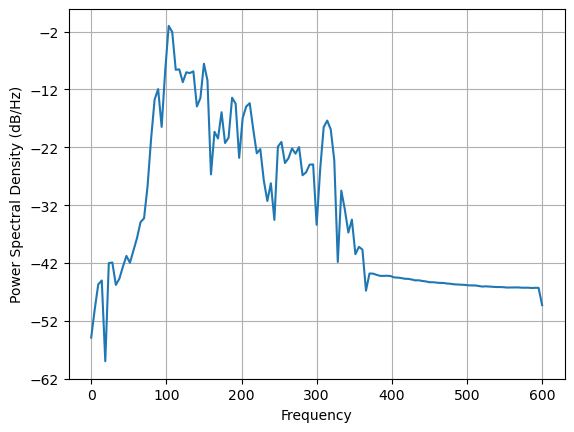

In [25]:
plt.figure()
plt.psd(raw.get_data()[25, 10000:10200], Fs=raw.info['sfreq'])
plt.show()

In [26]:
order = 12  # define model order

# Estimate AR models on raw data
b, a = fit_iir_model_raw(raw, order=order, picks=['ecog'], tmin=sample_time[0], tmax=sample_time[-1])
d, times = raw[25, 10000:10200]  # look at 25th channel for 200 samples
d = d.ravel()  # make flat vector
innovation = signal.convolve(d, a, 'valid')
d_ = signal.lfilter(b, a, innovation)  # regenerate the signal
d_ = np.r_[d_[0] * np.ones(order), d_]  # dummy samples to keep signal length

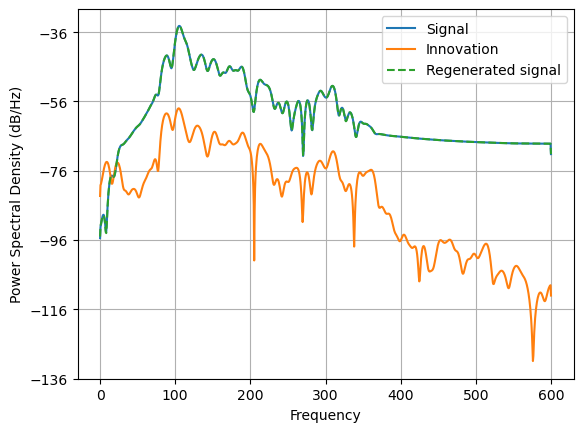

In [27]:
plt.figure()
plt.psd(d, Fs=raw.info['sfreq'], NFFT=2048)
plt.psd(innovation, Fs=raw.info['sfreq'], NFFT=2048)
plt.psd(d_, Fs=raw.info['sfreq'], NFFT=2048, linestyle='--')
plt.legend(('Signal', 'Innovation', 'Regenerated signal'))
plt.show()

In [28]:
m = raw._data
m.mean(), m.std(), m.shape

(3.4214274444060973, 67.12192549848798, (62, 507025))

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 1.707 (s)


/home/saras/miniconda3/envs/bci/lib/python3.10/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


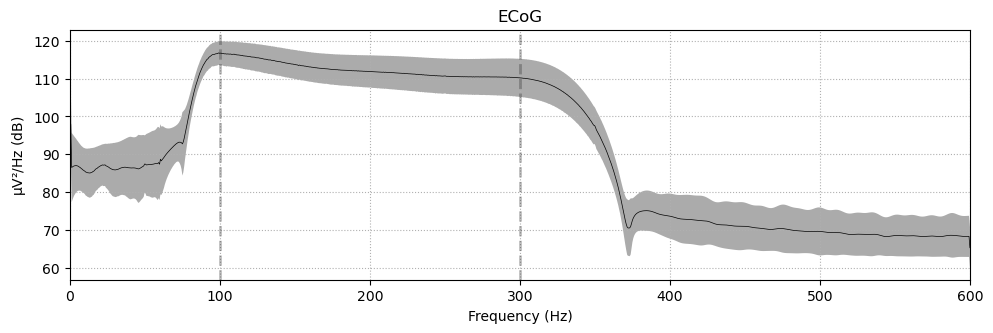

In [29]:
raw.plot_psd(average=True)
plt.show()

In [30]:
event_labels = dict(fist_movement = 1, peace_movement = 2, open_hand = 3)
# find events in the MNE raw object
events = mne.find_events(raw, stim_channel="paradigm_info", shortest_event=1, verbose=True)

90 events found
Event IDs: [1 2 3]


In [31]:
epochs = mne.Epochs(raw, events, tmin=-0.75, tmax=0.75, proj=True,
                    picks=('ecog'), baseline=(None, 0.), preload=True,
                    verbose='error')

In [32]:
import scipy.io as sio
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import LabelEncoder
import mne.decoding
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from mne.decoding import Vectorizer, Scaler, cross_val_multiscore

In [33]:
X = epochs.get_data() # n_epochs, n_channels, n_times
y = epochs.events[:, 2]

X.shape, y.shape

((90, 60, 1801), (90,))

In [34]:
X.shape[0] != y.shape[0]

False

In [35]:
# Reshape the 3D array into a 2D array while keeping n_channels dimension
X = X.reshape(90, -1)

X.shape, y.shape

((90, 108060), (90,))

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(72, 108060) (18, 108060) (72,) (18,)


Neural Network

In [37]:
encoder = LabelEncoder()
encoder.fit([1, 2, 3])
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

In [38]:
unique_y_train_values = np.unique(y_train)
unique_y_test_values = np.unique(y_test)

In [39]:
# Reshape the data into the required input shape for the LSTM model
timesteps = 1  # the number of timesteps
n_features = X_train.shape[1]

print(n_features)

108060


In [40]:
X_train = X_train.reshape(-1, timesteps, n_features)
X_test = X_test.reshape(-1, timesteps, n_features)

In [41]:
import torch
import torch.nn as nn
from sklearn.decomposition import PCA

In [42]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_prob=0.5, device="cpu"):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.device = device
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob).to(self.device)
        self.fc = nn.Linear(hidden_size, num_classes).to(self.device)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
    
    def get_hidden_states(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        _, (hidden_states, _) = self.lstm(x, (h0, c0))
        return hidden_states

device = "cpu"
print(f"Using {device} device")

Using cpu device


In [43]:
# Set the number of PCA components
n_pca_components = 60

In [44]:
# Apply PCA to the train and test datasets

X_train_2d = X_train.reshape(X_train.shape[0], -1)
X_test_2d = X_test.reshape(X_test.shape[0], -1)

pca = PCA(n_components=n_pca_components)
X_train_pca = pca.fit_transform(X_train_2d)
X_test_pca = pca.transform(X_test_2d)

X_train_pca = X_train_pca.reshape(X_train.shape[0], X_train.shape[1], n_pca_components)
X_test_pca = X_test_pca.reshape(X_test.shape[0], X_test.shape[1], n_pca_components)

X_train_pca_tensor = torch.tensor(X_train_pca, dtype=torch.float32).to(device)
X_test_pca_tensor = torch.tensor(X_test_pca, dtype=torch.float32).to(device)

In [45]:
X_train_pca_tensor.shape, X_test_pca_tensor.shape

(torch.Size([72, 1, 60]), torch.Size([18, 1, 60]))

In [46]:
input_size = n_pca_components
hidden_size = 128
num_layers = 2
num_classes = len(np.unique(y))

In [47]:
model = LSTMModel(input_size, hidden_size, num_layers, num_classes, device='cpu').to(device)

In [48]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

In [49]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
losses = []

In [50]:
# Train the model
num_epochs = 1000
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train_pca_tensor)
    loss = criterion(outputs, y_train_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Record the loss
    losses.append(loss.item())

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/1000], Loss: 1.0085
Epoch [20/1000], Loss: 0.8996
Epoch [30/1000], Loss: 0.7534
Epoch [40/1000], Loss: 0.5632
Epoch [50/1000], Loss: 0.4119
Epoch [60/1000], Loss: 0.2661
Epoch [70/1000], Loss: 0.2122
Epoch [80/1000], Loss: 0.1169
Epoch [90/1000], Loss: 0.0689
Epoch [100/1000], Loss: 0.1188
Epoch [110/1000], Loss: 0.0613
Epoch [120/1000], Loss: 0.0694
Epoch [130/1000], Loss: 0.0395
Epoch [140/1000], Loss: 0.0378
Epoch [150/1000], Loss: 0.0158
Epoch [160/1000], Loss: 0.0614
Epoch [170/1000], Loss: 0.0479
Epoch [180/1000], Loss: 0.0252
Epoch [190/1000], Loss: 0.0265
Epoch [200/1000], Loss: 0.0197
Epoch [210/1000], Loss: 0.0159
Epoch [220/1000], Loss: 0.0348
Epoch [230/1000], Loss: 0.0146
Epoch [240/1000], Loss: 0.0094
Epoch [250/1000], Loss: 0.0074
Epoch [260/1000], Loss: 0.0192
Epoch [270/1000], Loss: 0.0031
Epoch [280/1000], Loss: 0.0236
Epoch [290/1000], Loss: 0.0089
Epoch [300/1000], Loss: 0.0099
Epoch [310/1000], Loss: 0.0095
Epoch [320/1000], Loss: 0.0042
Epoch [330/1000],

In [51]:
# Make predictions using the trained LSTM model
y_pred_train = model(X_train_pca_tensor).cpu().detach().numpy()
y_pred_test = model(X_test_pca_tensor).cpu().detach().numpy()

In [52]:
# Get the class labels
y_pred_train_labels = np.argmax(y_pred_train, axis=1)
y_pred_test_labels = np.argmax(y_pred_test, axis=1)

In [53]:
# Calculate the accuracy
train_accuracy = np.sum(y_pred_train_labels == y_train) / len(y_train)
test_accuracy = np.sum(y_pred_test_labels == y_test) / len(y_test)

print(f"Train accuracy: {train_accuracy * 100:.2f}%")
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

Train accuracy: 100.00%
Test accuracy: 27.78%


In [54]:
from sklearn.metrics import f1_score

# Ensure that y_test and y_pred_test_labels have the same shape
assert y_test.shape == y_pred_test_labels.shape, "y_test and y_pred_test_labels should have the same shape"
# Calculate the F1 score
f1 = f1_score(y_test, y_pred_test_labels, average='weighted')

print("F1 score: {:.2f}".format(f1))

F1 score: 0.27


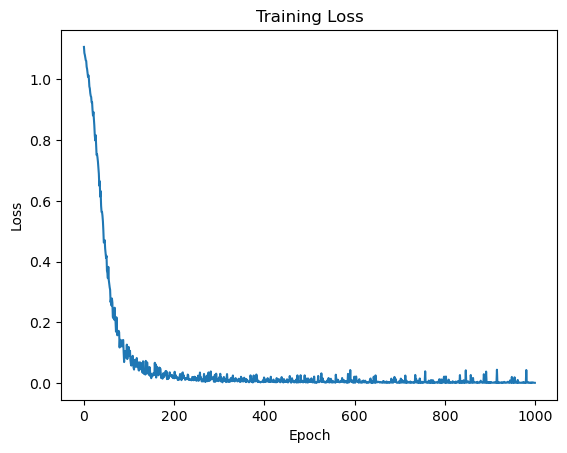

In [55]:
# Visualize the training loss

import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')

y_ticks = np.arange(0, np.max(losses), 0.2)
plt.yticks(y_ticks)
plt.savefig('training_loss.png', dpi=300, bbox_inches='tight')
plt.show();

SkLearn models

In [56]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP

In [57]:
# X = epochs.get_data() # n_epochs, n_channels, n_times
# y = epochs.events[:, 2]

# X.shape, y.shape

epochs = mne.Epochs(raw, events, tmin=-0.75, tmax=0.75, proj=True, picks=['ecog'],
                baseline=None, preload=True)
epochs_train = epochs.copy().crop(tmin=-0.75, tmax=0.75)
labels = epochs.events[:, -1] - 2

Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 90 events and 1801 original time points ...
0 bad epochs dropped


In [58]:
# Define a monte-carlo cross-validation generator (reduce variance):
scores = []
epochs_data = epochs.get_data()
epochs_data_train = epochs_train.get_data()
cv = ShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(epochs_data_train)

# Assemble a classifier
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

# Use scikit-learn Pipeline with cross_val_score function
clf = Pipeline([('CSP', csp), ('LDA', lda)])
scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=None)

# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores),
                                                          class_balance))

# plot CSP patterns estimated on full data for visualization
csp.fit_transform(epochs_data, labels)

csp.plot_patterns(epochs.info, ch_type='ecog', units='Patterns (AU)', size=1.5)

Computing rank from data with rank=None
    Using tolerance 21 (2.2e-16 eps * 60 dim * 1.6e+15  max singular value)
    Estimated rank (mag): 60
    MAG: rank 60 computed from 60 data channels with 0 projectors
Reducing data rank from 60 -> 60
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 21 (2.2e-16 eps * 60 dim * 1.6e+15  max singular value)
    Estimated rank (mag): 60
    MAG: rank 60 computed from 60 data channels with 0 projectors
Reducing data rank from 60 -> 60
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 17 (2.2e-16 eps * 60 dim * 1.2e+15  max singular value)
    Estimated rank (mag): 60
    MAG: rank 60 computed from 60 data channels with 0 projectors
Reducing data rank from 60 -> 60
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 22 (2.2e-16 eps * 60 dim * 1.6e+15  max singular value)
    Estimated rank (

/home/saras/miniconda3/envs/bci/lib/python3.10/site-packages/mne/decoding/csp.py:617: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(omega12 * omega21)
/home/saras/miniconda3/envs/bci/lib/python3.10/site-packages/mne/decoding/csp.py:619: RuntimeWarning: invalid value encountered in sqrt
  tmp = np.sqrt(omega21 / omega12)


    Using tolerance 22 (2.2e-16 eps * 60 dim * 1.7e+15  max singular value)
    Estimated rank (mag): 60
    MAG: rank 60 computed from 60 data channels with 0 projectors
Reducing data rank from 60 -> 60
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 20 (2.2e-16 eps * 60 dim * 1.5e+15  max singular value)
    Estimated rank (mag): 60
    MAG: rank 60 computed from 60 data channels with 0 projectors
Reducing data rank from 60 -> 60
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 16 (2.2e-16 eps * 60 dim * 1.2e+15  max singular value)
    Estimated rank (mag): 60
    MAG: rank 60 computed from 60 data channels with 0 projectors
Reducing data rank from 60 -> 60
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 21 (2.2e-16 eps * 60 dim * 1.6e+15  max singular value)
    Estimated rank (mag): 60
    MAG: rank 60 computed from 

/home/saras/miniconda3/envs/bci/lib/python3.10/site-packages/mne/decoding/csp.py:617: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(omega12 * omega21)
/home/saras/miniconda3/envs/bci/lib/python3.10/site-packages/mne/decoding/csp.py:619: RuntimeWarning: invalid value encountered in sqrt
  tmp = np.sqrt(omega21 / omega12)


Computing rank from data with rank=None
    Using tolerance 19 (2.2e-16 eps * 60 dim * 1.4e+15  max singular value)
    Estimated rank (mag): 60
    MAG: rank 60 computed from 60 data channels with 0 projectors
Reducing data rank from 60 -> 60
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 22 (2.2e-16 eps * 60 dim * 1.7e+15  max singular value)
    Estimated rank (mag): 60
    MAG: rank 60 computed from 60 data channels with 0 projectors
Reducing data rank from 60 -> 60
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 17 (2.2e-16 eps * 60 dim * 1.3e+15  max singular value)
    Estimated rank (mag): 60
    MAG: rank 60 computed from 60 data channels with 0 projectors
Reducing data rank from 60 -> 60
Estimating covariance using EMPIRICAL
Done.
Classification accuracy: nan / Chance level: 0.666667
Computing rank from data with rank=None


/home/saras/miniconda3/envs/bci/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
2 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
ValueError: On entry to DLASCL parameter number 4 had an illegal value

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/saras/miniconda3/envs/bci/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/saras/miniconda3/envs/bci/lib/python3.10/site-packages/sklearn/pipeline.py", line 401, in fit
    Xt = self._fit(X, y, *

    Using tolerance 24 (2.2e-16 eps * 60 dim * 1.8e+15  max singular value)
    Estimated rank (mag): 60
    MAG: rank 60 computed from 60 data channels with 0 projectors
Reducing data rank from 60 -> 60
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 23 (2.2e-16 eps * 60 dim * 1.8e+15  max singular value)
    Estimated rank (mag): 60
    MAG: rank 60 computed from 60 data channels with 0 projectors
Reducing data rank from 60 -> 60
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 18 (2.2e-16 eps * 60 dim * 1.4e+15  max singular value)
    Estimated rank (mag): 60
    MAG: rank 60 computed from 60 data channels with 0 projectors
Reducing data rank from 60 -> 60
Estimating covariance using EMPIRICAL
Done.


/home/saras/miniconda3/envs/bci/lib/python3.10/site-packages/mne/decoding/csp.py:617: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(omega12 * omega21)
/home/saras/miniconda3/envs/bci/lib/python3.10/site-packages/mne/decoding/csp.py:619: RuntimeWarning: invalid value encountered in sqrt
  tmp = np.sqrt(omega21 / omega12)


SystemError: <class 'numpy.linalg.LinAlgError'> returned a result with an exception set

In [ ]:
# split train test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [ ]:
# Define CSP parameters
n_components = 4  # Number of CSP components
transformer = CSP(n_components=n_components, reg=None, log=True, norm_trace=False)

# Apply CSP to training data
X_train_csp = transformer.fit_transform(X_train, y_train)

# Apply CSP to testing data
X_test_csp = transformer.transform(X_test)

# Train a classifier on the CSP features
clf = SVC(kernel='linear')
clf.fit(X_train_csp, y_train)

# Evaluate the classifier on the testing set
accuracy = clf.score(X_test_csp, y_test)
print('Accuracy:', accuracy)

Computing rank from data with rank=None
    Using tolerance 21 (2.2e-16 eps * 60 dim * 1.6e+15  max singular value)
    Estimated rank (mag): 60
    MAG: rank 60 computed from 60 data channels with 0 projectors
Reducing data rank from 60 -> 60
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 21 (2.2e-16 eps * 60 dim * 1.6e+15  max singular value)
    Estimated rank (mag): 60
    MAG: rank 60 computed from 60 data channels with 0 projectors
Reducing data rank from 60 -> 60
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 17 (2.2e-16 eps * 60 dim * 1.3e+15  max singular value)
    Estimated rank (mag): 60
    MAG: rank 60 computed from 60 data channels with 0 projectors
Reducing data rank from 60 -> 60
Estimating covariance using EMPIRICAL
Done.


/home/saras/miniconda3/envs/bci/lib/python3.10/site-packages/mne/decoding/csp.py:617: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(omega12 * omega21)
/home/saras/miniconda3/envs/bci/lib/python3.10/site-packages/mne/decoding/csp.py:619: RuntimeWarning: invalid value encountered in sqrt
  tmp = np.sqrt(omega21 / omega12)


SystemError: <class 'numpy.linalg.LinAlgError'> returned a result with an exception set

In [ ]:
# dimensionality reduction
from sklearn.decomposition import PCA

n_pca_components = 60

X_2d = X.reshape(X.shape[0], -1)

pca = PCA(n_components=n_pca_components)
X_pca = pca.fit_transform(X_2d)

X_pca.shape

(90, 60)

In [ ]:
# train the data with random forest and grid search for hyperparameters
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier()
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
    }

CV_rfc = GridSearchCV(estimator=rf, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

print(CV_rfc.best_params_)
print(CV_rfc.best_score_)
print(CV_rfc.best_estimator_)
print(CV_rfc.best_index_)
print(CV_rfc.scorer_)
print(CV_rfc.n_splits_)
print(CV_rfc.refit_time_)
print(CV_rfc.cv_results_)
print(CV_rfc.cv)

# test the model on the test data
y_pred = CV_rfc.predict(X_test)

# calculate accuracy
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

# plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show();

ValueError: 
All the 500 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
500 fits failed with the following error:
Traceback (most recent call last):
  File "/home/saras/miniconda3/envs/bci/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/saras/miniconda3/envs/bci/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 345, in fit
    X, y = self._validate_data(
  File "/home/saras/miniconda3/envs/bci/lib/python3.10/site-packages/sklearn/base.py", line 584, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/home/saras/miniconda3/envs/bci/lib/python3.10/site-packages/sklearn/utils/validation.py", line 1106, in check_X_y
    X = check_array(
  File "/home/saras/miniconda3/envs/bci/lib/python3.10/site-packages/sklearn/utils/validation.py", line 915, in check_array
    raise ValueError(
ValueError: Found array with dim 3. RandomForestClassifier expected <= 2.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


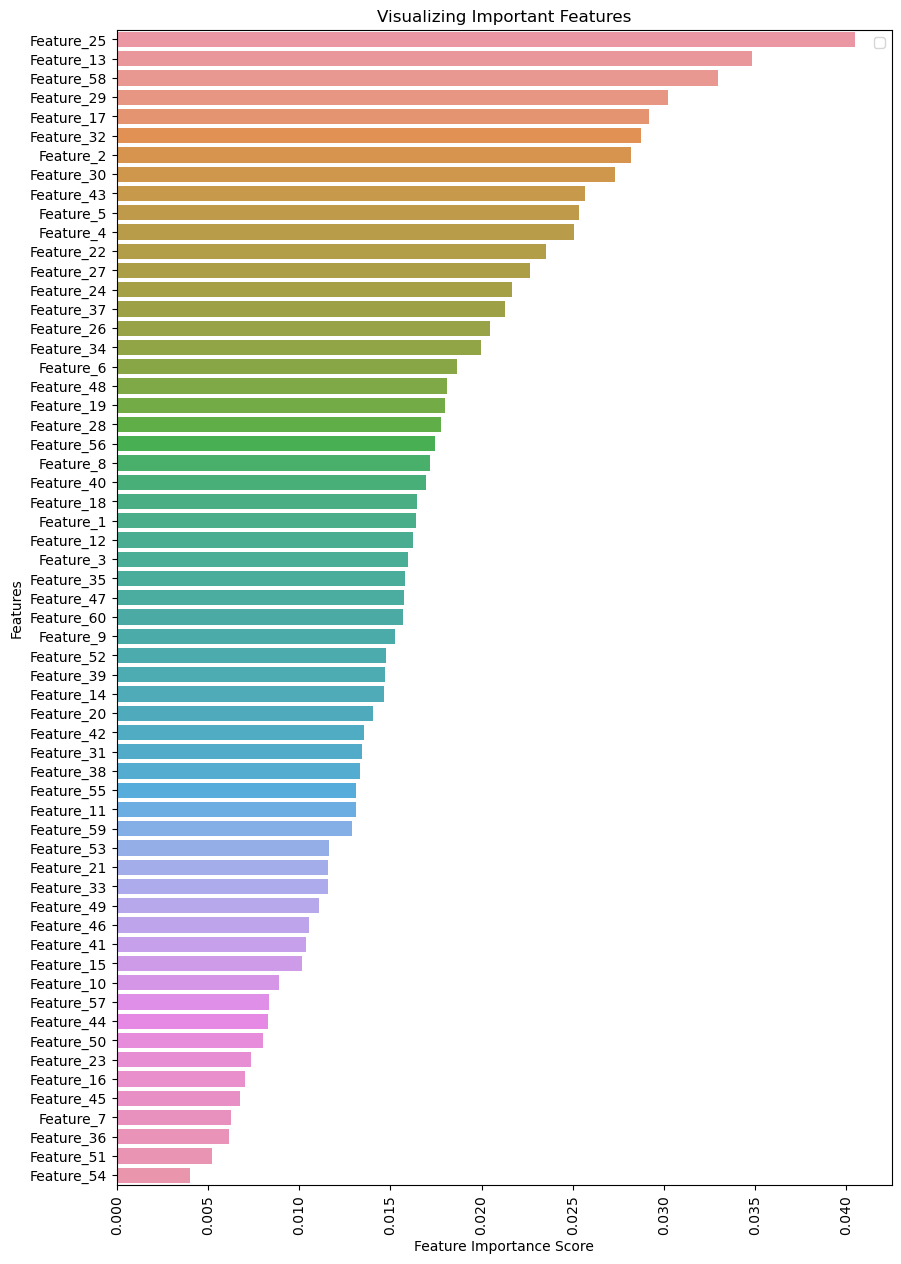

In [ ]:
# plot the feature importance
import pandas as pd
feature_imp = pd.Series(CV_rfc.best_estimator_.feature_importances_,index=[f'Feature_{i}' for i in range(1, 61)]).sort_values(ascending=False)
sns.barplot(x=feature_imp, y=feature_imp.index)
# resize the plot
plt.gcf().set_size_inches(10, 15)
plt.xlabel('Feature Importance Score')
# tilt the x-axis labels
plt.xticks(rotation=90)
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show();

{'n_components': None, 'shrinkage': None, 'solver': 'lsqr'}
0.43047619047619046
LinearDiscriminantAnalysis(solver='lsqr')
2
<function _passthrough_scorer at 0x7ff0c84b5a20>
5
0.0014688968658447266
{'mean_fit_time': array([0.00332122, 0.00403128, 0.00153747, 0.00121818, 0.00154295,
       0.00189857, 0.00150089, 0.00182881, 0.00150003, 0.001932  ,
       0.001511  , 0.00183682, 0.00149794, 0.00190215, 0.00151262,
       0.00185957, 0.00152159, 0.00189738, 0.00151258, 0.00186977,
       0.00151291, 0.00191727, 0.00265856, 0.0033289 , 0.00134082,
       0.00117393, 0.00149751, 0.00187716, 0.00150023, 0.00185652,
       0.00147185, 0.0018352 , 0.00151963, 0.00185609, 0.00147762,
       0.00185556, 0.00152712, 0.00185995, 0.00148907, 0.00186486,
       0.00150366, 0.00187173, 0.00148902, 0.00188694, 0.00260096,
       0.00361843, 0.00132718, 0.00117307, 0.00152822, 0.00186491,
       0.00148082, 0.00186543, 0.00146956, 0.00186229, 0.00153451,
       0.00186281, 0.00148902, 0.00186195, 0.001

/home/saras/miniconda3/envs/bci/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
895 fits failed out of a total of 1210.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/home/saras/miniconda3/envs/bci/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/saras/miniconda3/envs/bci/lib/python3.10/site-packages/sklearn/discriminant_analysis.py", line 631, in fit
    self._solve_eigen(
  File "/home/saras/miniconda3/envs/bci/lib/python3.10/site-packages/sklearn/discriminant_analysis.py", line 463, in _solve_eige

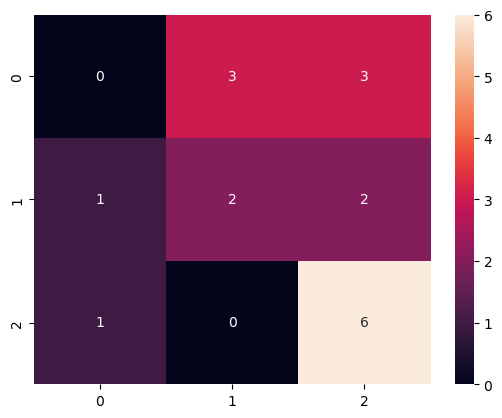

In [ ]:
# train with rLDA and grid search for hyperparameters
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV

lda = LinearDiscriminantAnalysis()
param_grid = {
    'solver': ['lsqr', 'eigen'],
    'shrinkage': ['auto', None, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    'n_components': [None, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    }

CV_lda = GridSearchCV(estimator=lda, param_grid=param_grid, cv= 5)
CV_lda.fit(X_train, y_train)

print(CV_lda.best_params_)
print(CV_lda.best_score_)
print(CV_lda.best_estimator_)
print(CV_lda.best_index_)
print(CV_lda.scorer_)
print(CV_lda.n_splits_)
print(CV_lda.refit_time_)
print(CV_lda.cv_results_)
print(CV_lda.cv)

# test the model on the test data
y_pred = CV_lda.predict(X_test)

# calculate accuracy
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

# plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show();

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


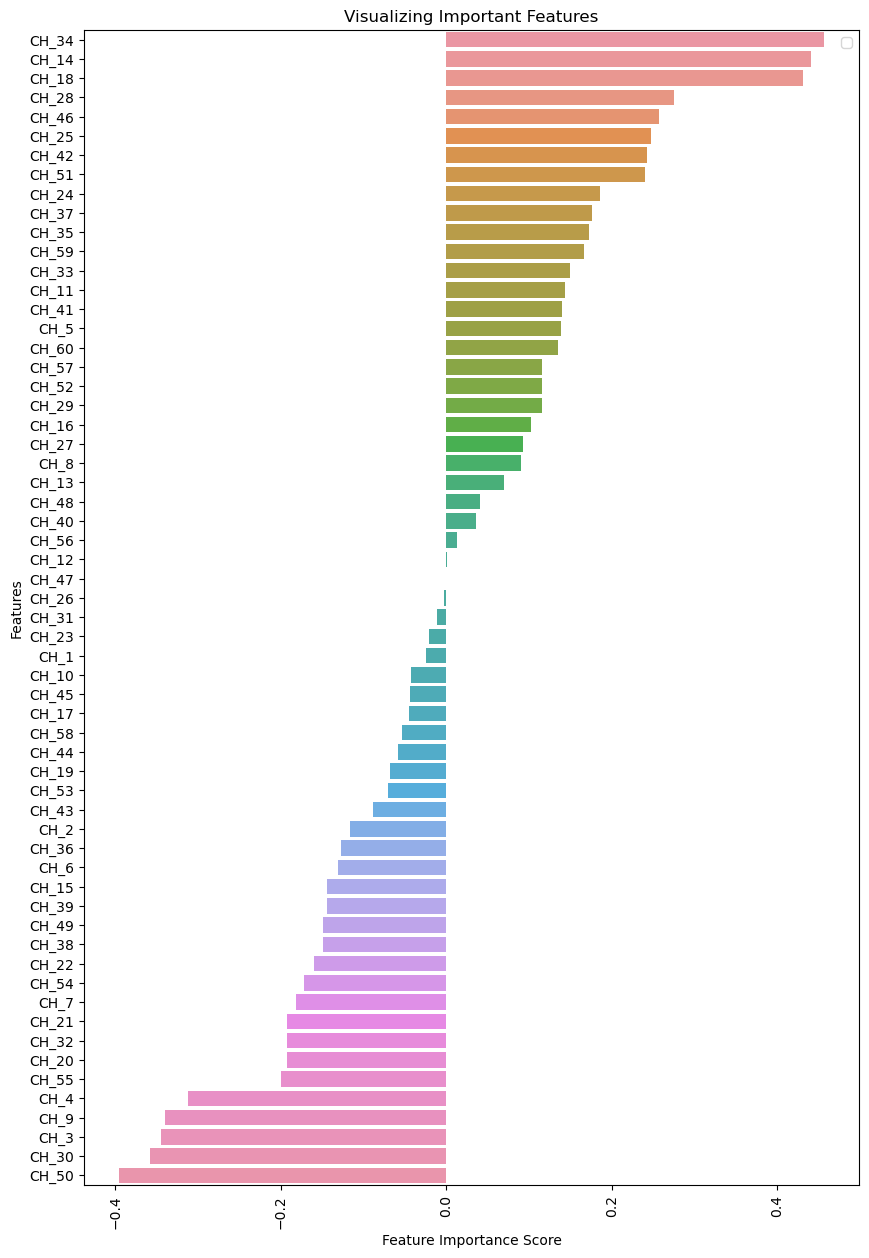

In [ ]:
# plot the feature importance
import pandas as pd
feature_imp = pd.Series(CV_lda.best_estimator_.coef_[0],index=epochs.ch_names).sort_values(ascending=False)
sns.barplot(x=feature_imp, y=feature_imp.index)
# resize the plot
plt.gcf().set_size_inches(10, 15)
plt.xlabel('Feature Importance Score')
# tilt the x-axis labels
plt.xticks(rotation=90)
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show();

In [ ]:
from tqdm.auto import tqdm, trange
import random


random.seed(16)
data = epochs.get_data()
n_splits = 16
n_folds = 3
fold_size = len(data) // n_folds
folds = []
for s in trange(n_splits):
    fold = []
    ts = list(range(len(data)))
    random.shuffle(ts)
    for i in range(0, len(data), fold_size):
        x = data[ts][i:i+fold_size]
        y = epochs.events[ts][i:i+fold_size, -1]
        fold.append((x, y))
    folds.append(fold)

  0%|          | 0/16 [00:00<?, ?it/s]

In [ ]:
# evoked = epochs.average().resample(200)

sfreq = 1200
gamma_power_t = epochs.copy().filter(30, 150).apply_hilbert(envelope=True).resample(sfreq)
gamma_info = gamma_power_t.info

Setting up band-pass filter from 30 - 1.5e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 150.00 Hz
- Upper transition bandwidth: 37.50 Hz (-6 dB cutoff frequency: 168.75 Hz)
- Filter length: 529 samples (0.441 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 5400 out of 5400 | elapsed:    0.9s finished
